In [29]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.utils import resample

In [30]:
df = pd.read_csv('mtsamples.csv')
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [31]:
# Affichage avant suppression
print(f"Nombre de lignes AVANT suppression des doublons : {df.shape[0]}")

# Comptage des doublons dans la colonne
nb_doublons = df.duplicated().sum()
print(f"Nombre de doublons trouvés :  {nb_doublons}")

# Suppression des doublons
df = df.drop_duplicates()

# Affichage après suppression
print(f"Nombre de lignes APRÈS suppression des doublons : {df.shape[0]}")

Nombre de lignes AVANT suppression des doublons : 4999
Nombre de doublons trouvés :  0
Nombre de lignes APRÈS suppression des doublons : 4999


In [32]:
print("Nombre de valeurs manquantes par colonne :")
print(df.isnull().sum())

Nombre de valeurs manquantes par colonne :
Unnamed: 0              0
description             0
medical_specialty       0
sample_name             0
transcription          33
keywords             1069
dtype: int64


In [33]:
# 1. Replace empty strings or strings with only spaces by NaN
df["keywords"] = df["keywords"].replace(r'^\s*$', np.nan, regex=True)

# 2. Fill NaN values by the mode of 'keywords' per 'medical_specialty' or 'unknown'
keyword_mode_by_specialty = df.groupby("medical_specialty")["keywords"].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "unknown")
)

# 3. Final replacement in the original column
df["keywords"] = df["keywords"].fillna(keyword_mode_by_specialty)


In [34]:
print(f"Nombre de 'unknown' dans keywords : {(df['keywords'] == 'unknown').sum()}")

Nombre de 'unknown' dans keywords : 8


In [35]:
# Get the most frequent value (mode) in 'keywords'
mode_value = df['keywords'].mode()[0]

# Count how many times it appears
mode_count = df['keywords'].value_counts().loc[mode_value]

# Display the result
print(f"Most Frequent Keyword: '{mode_value}'  |  Count: {mode_count}")

Most Frequent Keyword: 'consult - history and phy., accutane, possibility of foreign body, foot etiology, foreign body, infection, foot, abscess,'  |  Count: 297


In [36]:
df['transcription'] = df['transcription'].fillna('Not transcribed')

In [37]:
# Get the most frequent value (mode)
mode_value = df['transcription'].mode()[0]

# Count how many times it appears
mode_count = df['transcription'].value_counts().loc[mode_value]

# Display the result
print(f"Most Frequent : '{mode_value}'  |  Count: {mode_count}")

Most Frequent : 'Not transcribed'  |  Count: 33


In [38]:
print("Nombre de valeurs manquantes par colonne :")
print(df.isnull().sum())

Nombre de valeurs manquantes par colonne :
Unnamed: 0           0
description          0
medical_specialty    0
sample_name          0
transcription        0
keywords             0
dtype: int64


In [39]:
df

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...,...,...,...,...
4994,4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...","allergy / immunology, allergic rhinitis, aller..."
4995,4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...","allergy / immunology, allergic rhinitis, aller..."
4997,4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen...","allergy / immunology, allergic rhinitis, aller..."


In [40]:
# Nettoyage amélioré
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].apply(lambda text:
        re.sub(r'\s+', ' ',
        re.sub(r'[^1-9a-zA-Z]', ' ', text))     # <= remplace par espace au lieu de supprimer
        .strip().lower() if isinstance(text, str) else text
    )

In [41]:
df

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,a 23 year old white female presents with compl...,allergy immunology,allergic rhinitis,subjective this 23 year old white female prese...,allergy immunology allergic rhinitis allergies...
1,1,consult for laparoscopic gastric bypass,bariatrics,laparoscopic gastric bypass consult 2,past medical history he has difficulty climbin...,bariatrics laparoscopic gastric bypass weight ...
2,2,consult for laparoscopic gastric bypass,bariatrics,laparoscopic gastric bypass consult 1,history of present illness i have seen abc tod...,bariatrics laparoscopic gastric bypass heart a...
3,3,2 d m mode doppler,cardiovascular pulmonary,2 d echocardiogram 1,2 d m mode 1 left atrial enlargement with left...,cardiovascular pulmonary 2 d m mode doppler ao...
4,4,2 d echocardiogram,cardiovascular pulmonary,2 d echocardiogram 2,1 the left ventricular cavity size and wall th...,cardiovascular pulmonary 2 d doppler echocardi...
...,...,...,...,...,...,...
4994,4994,patient having severe sinusitis about two to t...,allergy immunology,chronic sinusitis,history i had the pleasure of meeting and eval...,allergy immunology allergic rhinitis allergies...
4995,4995,this is a 14 month old baby boy caucasian who ...,allergy immunology,kawasaki disease discharge summary,admitting diagnosis kawasaki disease discharge...,allergy immunology mucous membranes conjunctiv...
4996,4996,a female for a complete physical and follow up...,allergy immunology,followup on asthma,subjective this is a 42 year old white female ...,allergy immunology allergic rhinitis allergies...
4997,4997,mother states he has been wheezing and coughing,allergy immunology,asthma in a 5 year old,chief complaint this 5 year old male presents ...,allergy immunology allergic rhinitis allergies...


In [42]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].apply(lambda text: text.split() if isinstance(text, str) else text)

In [43]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].apply(lambda text: text.split() if isinstance(text, str) else text)
    print(f"Exemple de tokens dans la colonne '{col}':")
    print(df[col].iloc[0])  # Affiche la première ligne de la colonne transformée
    print('---')

Exemple de tokens dans la colonne 'description':
['a', '23', 'year', 'old', 'white', 'female', 'presents', 'with', 'complaint', 'of', 'allergies']
---
Exemple de tokens dans la colonne 'medical_specialty':
['allergy', 'immunology']
---
Exemple de tokens dans la colonne 'sample_name':
['allergic', 'rhinitis']
---
Exemple de tokens dans la colonne 'transcription':
['subjective', 'this', '23', 'year', 'old', 'white', 'female', 'presents', 'with', 'complaint', 'of', 'allergies', 'she', 'used', 'to', 'have', 'allergies', 'when', 'she', 'lived', 'in', 'seattle', 'but', 'she', 'thinks', 'they', 'are', 'worse', 'here', 'in', 'the', 'past', 'she', 'has', 'tried', 'claritin', 'and', 'zyrtec', 'both', 'worked', 'for', 'short', 'time', 'but', 'then', 'seemed', 'to', 'lose', 'effectiveness', 'she', 'has', 'used', 'allegra', 'also', 'she', 'used', 'that', 'last', 'summer', 'and', 'she', 'began', 'using', 'it', 'again', 'two', 'weeks', 'ago', 'it', 'does', 'not', 'appear', 'to', 'be', 'working', 'ver

In [44]:
df

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,"[a, 23, year, old, white, female, presents, wi...","[allergy, immunology]","[allergic, rhinitis]","[subjective, this, 23, year, old, white, femal...","[allergy, immunology, allergic, rhinitis, alle..."
1,1,"[consult, for, laparoscopic, gastric, bypass]",[bariatrics],"[laparoscopic, gastric, bypass, consult, 2]","[past, medical, history, he, has, difficulty, ...","[bariatrics, laparoscopic, gastric, bypass, we..."
2,2,"[consult, for, laparoscopic, gastric, bypass]",[bariatrics],"[laparoscopic, gastric, bypass, consult, 1]","[history, of, present, illness, i, have, seen,...","[bariatrics, laparoscopic, gastric, bypass, he..."
3,3,"[2, d, m, mode, doppler]","[cardiovascular, pulmonary]","[2, d, echocardiogram, 1]","[2, d, m, mode, 1, left, atrial, enlargement, ...","[cardiovascular, pulmonary, 2, d, m, mode, dop..."
4,4,"[2, d, echocardiogram]","[cardiovascular, pulmonary]","[2, d, echocardiogram, 2]","[1, the, left, ventricular, cavity, size, and,...","[cardiovascular, pulmonary, 2, d, doppler, ech..."
...,...,...,...,...,...,...
4994,4994,"[patient, having, severe, sinusitis, about, tw...","[allergy, immunology]","[chronic, sinusitis]","[history, i, had, the, pleasure, of, meeting, ...","[allergy, immunology, allergic, rhinitis, alle..."
4995,4995,"[this, is, a, 14, month, old, baby, boy, cauca...","[allergy, immunology]","[kawasaki, disease, discharge, summary]","[admitting, diagnosis, kawasaki, disease, disc...","[allergy, immunology, mucous, membranes, conju..."
4996,4996,"[a, female, for, a, complete, physical, and, f...","[allergy, immunology]","[followup, on, asthma]","[subjective, this, is, a, 42, year, old, white...","[allergy, immunology, allergic, rhinitis, alle..."
4997,4997,"[mother, states, he, has, been, wheezing, and,...","[allergy, immunology]","[asthma, in, a, 5, year, old]","[chief, complaint, this, 5, year, old, male, p...","[allergy, immunology, allergic, rhinitis, alle..."


In [45]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Supprimer les stopwords dans chaque colonne texte (chaque cellule contient une liste de mots)
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].apply(
        lambda tokens: [word for word in tokens if word not in stop_words]
        if isinstance(tokens, list) else tokens
    )
    print(f"Exemple sans stopwords pour la colonne '{col}':")
    print(df[col].iloc[0])  # Affiche un exemple
    print('---')

Exemple sans stopwords pour la colonne 'description':
['23', 'year', 'old', 'white', 'female', 'presents', 'complaint', 'allergies']
---
Exemple sans stopwords pour la colonne 'medical_specialty':
['allergy', 'immunology']
---
Exemple sans stopwords pour la colonne 'sample_name':
['allergic', 'rhinitis']
---


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BADR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Exemple sans stopwords pour la colonne 'transcription':
['subjective', '23', 'year', 'old', 'white', 'female', 'presents', 'complaint', 'allergies', 'used', 'allergies', 'lived', 'seattle', 'thinks', 'worse', 'past', 'tried', 'claritin', 'zyrtec', 'worked', 'short', 'time', 'seemed', 'lose', 'effectiveness', 'used', 'allegra', 'also', 'used', 'last', 'summer', 'began', 'using', 'two', 'weeks', 'ago', 'appear', 'working', 'well', 'used', 'counter', 'sprays', 'prescription', 'nasal', 'sprays', 'asthma', 'doest', 'require', 'daily', 'medication', 'think', 'flaring', 'medications', 'medication', 'currently', 'ortho', 'tri', 'cyclen', 'allegra', 'allergies', 'known', 'medicine', 'allergies', 'objective', 'vitals', 'weight', '13', 'pounds', 'blood', 'pressure', '124', '78', 'heent', 'throat', 'mildly', 'erythematous', 'without', 'exudate', 'nasal', 'mucosa', 'erythematous', 'swollen', 'clear', 'drainage', 'seen', 'tms', 'clear', 'neck', 'supple', 'without', 'adenopathy', 'lungs', 'clear', 'a

In [46]:
import nltk
from nltk.stem import PorterStemmer
nltk.download('punkt')  # pour tokenizer si besoin

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BADR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [47]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to convert Treebank POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Full preprocessing function with POS tagging and lemmatization
def preprocess_with_pos(text):
    if not isinstance(text, str):
        if pd.isnull(text):
            return ""
        text = str(text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip().lower()
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tagged_tokens = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged_tokens]
    return ' '.join(lemmatized)




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\BADR\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\BADR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\BADR\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\BADR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [48]:
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].apply(lambda x: ' '.join(map(str, x)) if isinstance(x, list) else x)

In [49]:
df

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,23 year old white female presents complaint al...,allergy immunology,allergic rhinitis,subjective 23 year old white female presents c...,allergy immunology allergic rhinitis allergies...
1,1,consult laparoscopic gastric bypass,bariatrics,laparoscopic gastric bypass consult 2,past medical history difficulty climbing stair...,bariatrics laparoscopic gastric bypass weight ...
2,2,consult laparoscopic gastric bypass,bariatrics,laparoscopic gastric bypass consult 1,history present illness seen abc today pleasan...,bariatrics laparoscopic gastric bypass heart a...
3,3,2 mode doppler,cardiovascular pulmonary,2 echocardiogram 1,2 mode 1 left atrial enlargement left atrial d...,cardiovascular pulmonary 2 mode doppler aortic...
4,4,2 echocardiogram,cardiovascular pulmonary,2 echocardiogram 2,1 left ventricular cavity size wall thickness ...,cardiovascular pulmonary 2 doppler echocardiog...
...,...,...,...,...,...,...
4994,4994,patient severe sinusitis two three months ago ...,allergy immunology,chronic sinusitis,history pleasure meeting evaluating patient re...,allergy immunology allergic rhinitis allergies...
4995,4995,14 month old baby boy caucasian came presumpti...,allergy immunology,kawasaki disease discharge summary,admitting diagnosis kawasaki disease discharge...,allergy immunology mucous membranes conjunctiv...
4996,4996,female complete physical follow asthma allergi...,allergy immunology,followup asthma,subjective 42 year old white female comes toda...,allergy immunology allergic rhinitis allergies...
4997,4997,mother states wheezing coughing,allergy immunology,asthma 5 year old,chief complaint 5 year old male presents child...,allergy immunology allergic rhinitis allergies...


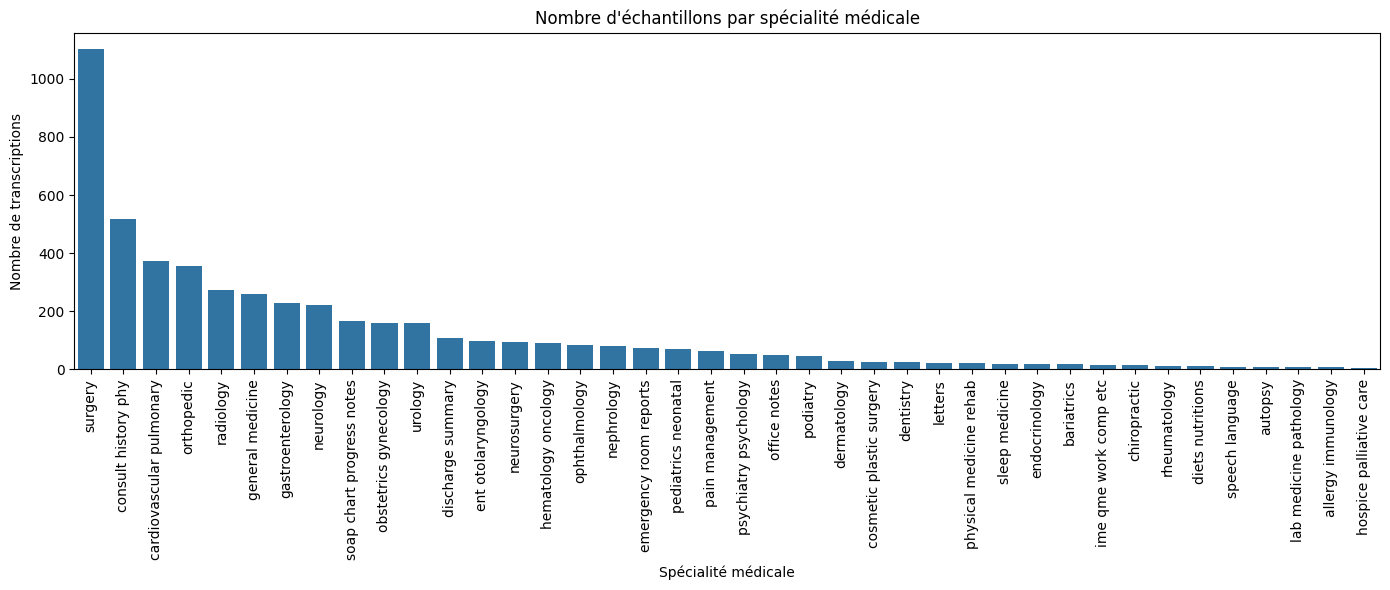

In [50]:
# Convertir les listes en chaînes si ce n’est pas encore fait
df['medical_specialty'] = df['medical_specialty'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# Tracer le countplot
plt.figure(figsize=(14, 6))
sns.countplot(x='medical_specialty', data=df, order=df['medical_specialty'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Nombre d'échantillons par spécialité médicale")
plt.xlabel("Spécialité médicale")
plt.ylabel("Nombre de transcriptions")
plt.tight_layout()
plt.show()

In [51]:
print(df["medical_specialty"].value_counts())

medical_specialty
surgery                      1103
consult history phy           516
cardiovascular pulmonary      372
orthopedic                    355
radiology                     273
general medicine              259
gastroenterology              230
neurology                     223
soap chart progress notes     166
obstetrics gynecology         160
urology                       158
discharge summary             108
ent otolaryngology             98
neurosurgery                   94
hematology oncology            90
ophthalmology                  83
nephrology                     81
emergency room reports         75
pediatrics neonatal            70
pain management                62
psychiatry psychology          53
office notes                   51
podiatry                       47
dermatology                    29
cosmetic plastic surgery       27
dentistry                      27
letters                        23
physical medicine rehab        21
sleep medicine                

In [52]:
# Optional: Group extremely rare classes
min_samples = 20
value_counts = df['medical_specialty'].value_counts()
rare_classes = value_counts[value_counts < min_samples].index
df['medical_specialty'] = df['medical_specialty'].apply(
    lambda x: 'other_specialties' if x in rare_classes else x
)

# Count after grouping
class_counts = df['medical_specialty'].value_counts()
max_class_size = 250  # Undersample limit
min_class_size = 150  # Oversample target

balanced_df = pd.DataFrame()

for label, group in df.groupby('medical_specialty'):
    if len(group) > max_class_size:
        # Undersample
        group = group.sample(n=max_class_size, random_state=42)
    elif len(group) < min_class_size:
        # Oversample using duplication (safe for DL)
        group = resample(group, replace=True, n_samples=min_class_size, random_state=42)
    balanced_df = pd.concat([balanced_df, group])

# Shuffle
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced dataset created:")
print(balanced_df['medical_specialty'].value_counts())

Balanced dataset created:
medical_specialty
cardiovascular pulmonary     250
general medicine             250
orthopedic                   250
radiology                    250
consult history phy          250
surgery                      250
gastroenterology             230
neurology                    223
soap chart progress notes    166
obstetrics gynecology        160
urology                      158
nephrology                   150
neurosurgery                 150
ent otolaryngology           150
dermatology                  150
physical medicine rehab      150
sleep medicine               150
other_specialties            150
ophthalmology                150
pediatrics neonatal          150
letters                      150
hematology oncology          150
cosmetic plastic surgery     150
podiatry                     150
emergency room reports       150
psychiatry psychology        150
dentistry                    150
discharge summary            150
pain management              150

In [53]:
# Optional: Save
balanced_df.to_csv("dl_balanced_medical_data.csv", index=False)

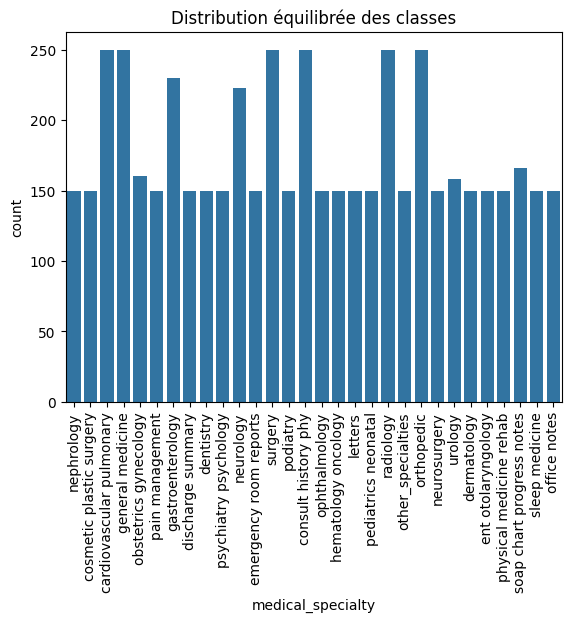

In [54]:
sns.countplot(data=balanced_df, x="medical_specialty")
plt.xticks(rotation=90)
plt.title("Distribution équilibrée des classes")
plt.show()

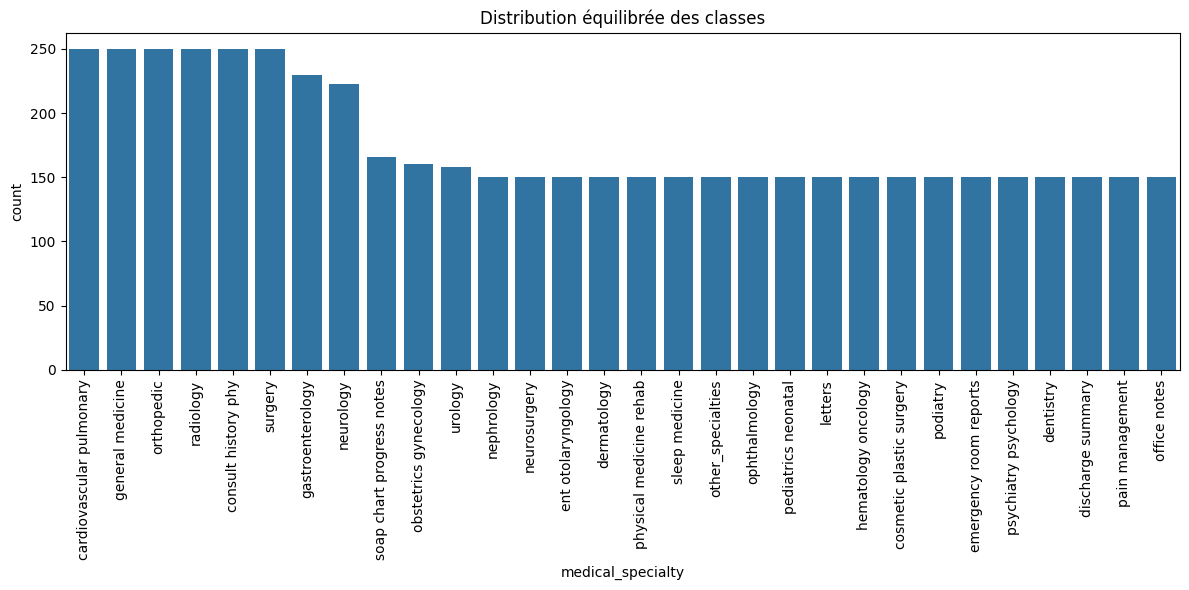

In [55]:
plt.figure(figsize=(12, 6))
sns.countplot(x='medical_specialty', data=balanced_df, order=balanced_df['medical_specialty'].value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribution équilibrée des classes")
plt.tight_layout()
plt.show()